<a href="https://colab.research.google.com/github/positmin/positmin/blob/main/00_Attention%EA%B3%BC_BERT_20221025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
## 20221025 10:10
## https://github.com/mrm8488/shared_colab_notebooks/blob/master/basic_self_attention_.ipynb

In [23]:
import tensorflow as tf
# 입력 데이터 (3개의 입력)
# 숫자가 의미 : embedding 되어진 결과 (imdb(어제 했었음) => 단어 매칭되어진 숫자)
x = [ [1, 0, 1, 0], [0, 2, 0, 2], [1, 1, 1, 1,] ] # 3x4

x = tf.convert_to_tensor(x, dtype=tf.float32)
print(x)

tf.Tensor(
[[1. 0. 1. 0.]
 [0. 2. 0. 2.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)


In [24]:
# 3개의 정보 : key, query(각 데이터와의 질의), value 상관성과 계산되어질 값
# 가중치에 의해서 학습
w_key = [ # 4x3 -> 3x3이 결과값으로 출력
    [0, 0, 1], # 랜덤하게 초기화된 값 ## 단어의 중요도가 고려될 수 있도록 학습 10:50
    [1, 1, 0],
    [0, 1, 0],
    [1, 1, 0]
]
w_query = [ # 다른 데이터와의 상관성을 구하기 위해서 구해지는 데이터의 대표값
    [1, 0, 1],
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 1]
]
w_value = [ # 상관성을 고려해야할 데이터의 값 -> 상관성(중요성을 고려한 값으로 재표현하기 위한 값) 10:34
    [0, 2, 0],
    [0, 3, 0],
    [1, 0, 3],
    [1, 1, 0]
]
w_key = tf.convert_to_tensor(w_key, dtype=tf.float32)
w_query = tf.convert_to_tensor(w_query, dtype=tf.float32)
w_value = tf.convert_to_tensor(w_value, dtype=tf.float32)

In [25]:
keys = tf.matmul(x, w_key) # x가 3x4이고, 키가 4x3이죠? => 3x3
querys = tf.matmul(x, w_query)
values = tf.matmul(x, w_value)
print(keys)
print(querys)
print(values)
# 내각 각 단어에 질문한다.
attn_scores = tf.matmul(querys, keys, transpose_b=True) # 행렬곱 -> attention_score -> 상관점수
print(attn_scores)

tf.Tensor(
[[0. 1. 1.]
 [4. 4. 0.]
 [2. 3. 1.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[1. 0. 2.]
 [2. 2. 2.]
 [2. 1. 3.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[1. 2. 3.]
 [2. 8. 0.]
 [2. 6. 3.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 2.  4.  4.]
 [ 4. 16. 12.]
 [ 4. 12. 10.]], shape=(3, 3), dtype=float32)


In [26]:
attn_scores_softmax = tf.nn.softmax(attn_scores, axis=-1) # 확률값으로 표현
print(attn_scores_softmax)
## 요 값들을 간단하게 정리하게 되면

tf.Tensor(
[[6.3378930e-02 4.6831051e-01 4.6831051e-01]
 [6.0336642e-06 9.8200780e-01 1.7986100e-02]
 [2.9538720e-04 8.8053685e-01 1.1916771e-01]], shape=(3, 3), dtype=float32)


In [27]:
# 정리한 값 -> 간단한 값으로 정리
## 간단하게 이해를 해보자 반올림 10:40
attn_scores_softmax = [
    [0.0, 0.5, 0.5],
    [0.0, 1.0, 0.0],
    [0.0, 0.9, 0.1]
]
attn_scores_softmax = tf.convert_to_tensor(attn_scores_softmax)
print(attn_scores_softmax)

tf.Tensor(
[[0.  0.5 0.5]
 [0.  1.  0. ]
 [0.  0.9 0.1]], shape=(3, 3), dtype=float32)


In [28]:
values[:,None]  # 3, 1, 3
tf.transpose(attn_scores_softmax)[:,:,None] # 3 x 3 x 1
# attention점수를 적용하는 과정

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[0. ],
        [0. ],
        [0. ]],

       [[0.5],
        [1. ],
        [0.9]],

       [[0.5],
        [0. ],
        [0.1]]], dtype=float32)>

In [29]:
values[:,None] # 3, 1, 3

<tf.Tensor: shape=(3, 1, 3), dtype=float32, numpy=
array([[[1., 2., 3.]],

       [[2., 8., 0.]],

       [[2., 6., 3.]]], dtype=float32)>

In [30]:
# 면 행 열로 이루어졌음 
# 3, 1, 3 3x3x1 => 곱하기 연산(행렬곱 아님)
# 중요도 ( 상관이 얼마나 되는지를 결정 ) : broadcasting 연산
## 맨 끝에 있는 놈이
weighted_values = values[:,None] * tf.transpose(attn_scores_softmax)[:,:,None]
print(weighted_values)
# 3x3x3 계산이 되죠

tf.Tensor(
[[[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[1.  4.  0. ]
  [2.  8.  0. ]
  [1.8 7.2 0. ]]

 [[1.  3.  1.5]
  [0.  0.  0. ]
  [0.2 0.6 0.3]]], shape=(3, 3, 3), dtype=float32)


In [31]:
# 입력데이터의 수에 맞추어서 각 데이터간의 중요도가 계산
# 그 중요도는 합해야 총합 중요도가 됨
outputs = tf.reduce_sum(weighted_values, axis=0) # 행으로 다 더해줌
print(outputs)
# 입력데이터의 차수 : 3x4가 그 단어 중요도를 고려한 3x3

tf.Tensor(
[[2.        7.        1.5      ]
 [2.        8.        0.       ]
 [2.        7.7999997 0.3      ]], shape=(3, 3), dtype=float32)


# keras를 이용한 attention 활용하는 내용

In [32]:
import tensorflow as tf
# RNN에서는 3차원으로 데이터 입력
# CNN은 4차원 장수, width, height, channel
inputs = tf.random.normal([32, 10, 8]) 
## 11:16 # 3차원, 32개수, 10 셀을 의미, 8은 각 셀에 입력되어지는 데이터의 차수
lstm = tf.keras.layers.LSTM(4) # RNN셀 LSTM셀 (입력 -> 출력, 수평으로 state선이 2개)
output = lstm(inputs)
lstm = tf.keras.layers.LSTM(4, return_sequences = True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)

In [33]:
# 행렬곱 : 다 곱해서 더해주는 값
# Control state
# Hidden state

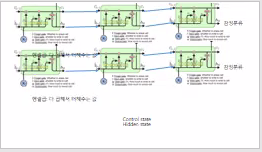

In [34]:
# 고급화 -> 추상화 (직접 연산은 사라지고 형태만 남음)
query_input = tf.keras.Input(shape=(None,), dtype='int32') # query
value_input = tf.keras.Input(shape=(None,), dtype='int32') # query
# one-hot-encoding (단어 수 만큼 벡터 크기가 커짐 -> 행렬이 희소 -> ACCURACY가 떨어짐)
# 일정한 크기의 벡터 -> 가중치 학습
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim = 64) # 64크기의 vector로 encoding
query_embeddings = token_embedding(query_input) # batchsize, 64
value_embeddings = token_embedding(value_input)
cnn_layer = tf.keras.layers.Conv1D( # CNN : Convolution연산은 주변을 고려한 특성
    filters=100, 
    kernel_size=4, # 4단어 사이의 특성을 고려한 값으로 재표현 : 가중치 형성
    padding='same')
query_seq_encoding = cnn_layer(query_embeddings) # 특성으로 표현된 query
value_seq_encoding = cnn_layer(value_embeddings)
query_value_attention_seq = tf.keras.layers.Attention()( # 상관중요도 - score가 계산 ## 11:32
    [query_seq_encoding, value_seq_encoding])
query_encoding = tf.keras.layers.GlobalAveragePooling1D()( # 각 단어 사이의 중요가도 결정이 되고 : 다 합쳐서 줄인다
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)
query_value_attention_seq = tf.keras.layers.GlobalAveragePooling1D()(
  [query_encoding, query_value_attention])
input_layer = tf.keras.layers.Concatenate()( # query_encoding + query_value_attention
   [query_encoding, query_value_attention])
# transformer를 구현하고 있음 : attention + LSTM

ValueError: ignored

In [35]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])


In [36]:
## https://keras.io/api/layers/attention_layers/attention/

In [37]:
## 11:10

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation
model = Sequential()
forward_layer = LSTM(10, return_sequences=True)
backward_layer = LSTM(10, activation='relu', return_sequences=True, go_backwards=True)
# 양방향 LSTM (long short time memory) + control state -> 가중치 소실되는 것을 막기 위해 + 회로로 구성
# RNN의 수평 연결점: 1개(위로 나가는 값과 옆으로 나가는 값이 동일)
# Bidirectional 양방향으로 특징
model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape = (5, 10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 20)            1680      
 l)                                                              
                                                                 
 dense (Dense)               (None, 5, 5)              105       
                                                                 
 activation (Activation)     (None, 5, 5)              0         
                                                                 
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
_________________________________________________________________


# AE(auto encoder)

In [38]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
# UpSampling2D
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data() ## 언더바로 받아서 재사용하지 않겠다라는 것임 11:56
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [39]:
# encoder 부분 -> 특징 추출
autoencoder = Sequential()
# 28 x 28 = 784 픽셀로 표현되는 이미지가 
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu')) # 128, 28, 28, 16
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 128 x 14 x 14 x 16
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same')) # 128 x 14 x 14 x 8
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 128 x 7 x 7 x 8
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # 128 x 4 x 4 x 8
# 특징 : 4 x 4 x 8 => 128 픽셀로 차원축소 === PCA ## 128개로 압축된거죠? ## 12:01
## 12:14 ## https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D

In [40]:
# decoder 부분 -> 원본 생성
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 128 x 4 x 4 x 8
autoencoder.add(UpSampling2D()) # 128 x 8 x 8 x 8
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 사이즈가 128 x 8 x 8 x 8
autoencoder.add(UpSampling2D()) # 128 x 16 x 16 x 8
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu')) ## 12:22 # padding의 디폴트 값은 valid # 128 x 14 x 14 x 16
autoencoder.add(UpSampling2D()) # 128 x 28 x 28 x 16
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='sigmoid')) # 128 x 28 x 28 x 1 # 원본 이미지 사이즈로 재생성
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)          

In [41]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
# UpSampling2D
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data() ## 언더바로 받아서 재사용하지 않겠다라는 것임 11:56
X_train = X_train.reshape(X_train.shape[0], 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28).astype('float32') / 255

In [42]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50


ValueError: ignored

In [ ]:
#생성자 모델 만들기
autoencoder = Sequential()

#인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=1, batch_size=128, validation_data=(X_test, X_test)) #epochs=50
# 컴파일 및 학습을 하는 부분

In [ ]:
# https://velog.io/@jjaa9292/%EB%94%A5%EB%9F%AC%EB%8B%9D5.-%EB%94%A5%EB%9F%AC%EB%8B%9D-%ED%99%9C%EC%9A%A9-4GAN

In [ ]:
# 비지도학습인데도 predict 결과값은 원본 이미지를 생성한 이미지
random_test = np.random.randint(X_test.shape[0], size=5)
ae_imgs = autoencoder.predict(X_test)

In [ ]:
# 원본 이미지
# 두번째는 생성 이미지
plt.figure(figsize=(7, 2))
for i, image_idx in enumerate(random_test):
  ax = plt.subplot(2, 7, i + 1)
  plt.imshow(X_test[image_idx].reshape(28, 28))
  ax.axis('off')
  ax = plt.subplot(2, 7, 7 + i + 1)
  plt.imshow(ae_imgs[image_idx].reshape(28, 28)) #
  ax.axis('off')
plt.show()

In [ ]:
## 12:15
import numpy as np
import tensorflow as tf
input_shape = (2, 2, 1, 3)
# np.sum()
x = np.arange(np.prod(input_shape)).reshape(input_shape)
print(x)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(x) # 행과 열을 의미
print(y)
# [[[[ 0  1  2]] [[ 0  1  2]] [[ 3  4  5]]] [[ 3  4  5]]]
#  [[[ 6  7  8]]  [[ 9 10 11]]]]

In [ ]:
## 12:27 ## 14:00 ## 16:00
# 문제
from tensorflow.keras import layers, losses
latent_dim = 64
# FFNN으로 생성된 모델
class Autoencoder(Model): ## 모델을 오토인코더가 상속을 받습니다
  def __init__(self, encoding_dim): # 구조를 설계
    super(Autoencoder, self).__init__() ## 먼저 모델의 초기화(__init__)를 호출
    self.latent_dim = latent_dim
    # 객체 : 매개변수로 리스트를 입력(레이어를 컴마로 분리해서 처리)
    self.encoder = tf.keras.Sequential([ # 분리해서 회로를 생성
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'), # 잠재변수 : 차원 축소
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'), # 64 * 784
        layers.Reshape((28, 28))
    ])
  def call(self, x): # call의 오버로딩 : 클래스를 함수처럼 호출할 때 사용
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder= Autoencoder(latent_dim)

In [ ]:
# https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError()) # tensorflow로 번역
# 문제 1 : fitting 시켜보시오 ## 12:35
# 문제 2 : 원본 이미지와 복원된 이미지를 출력해보시오

In [ ]:
# 정답
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                validation_data=(X_test, X_test))

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
# 정답
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
# UpSampling2D
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data() ## 언더바로 받아서 재사용하지 않겠다라는 것임 11:56
X_train = X_train.reshape(X_train.shape[0], 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28).astype('float32') / 255

In [ ]:
# 정답
plt.figure(figsize=(7,2))
for i, image_idx in enumerate(random_test):
  ax = plt.subplot(2, 7, i + 1)
  plt.imshow(X_test[image_idx].reshape(28, 28))
  ax.axis('off')
  ax = plt.subplot(2, 7, 7 + i + 1)
  plt.imshow(decoded_imgs[image_idx]) #
  ax.axis('off')

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Fashion_mnist AE로 특징을 추출하시오
- 차수를 확인하고 class base로 CNN을 가미해서 AE 망을 이용해서 64차원으로 특징을 추출하고 복원된 이미지를 출력해보시오.
- 개별 문제

In [46]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [47]:
## 정규화 ## 차수 확인
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [48]:
## 16:00
# encoder 부분 -> 특징 추출
autoencoder = Sequential()
# 28 x 28 = 784 픽셀로 표현되는 이미지가 
## 16:00 레이어를 추가하는 방식?
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu')) # 128, 28, 28, 16
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 128 x 14 x 14 x 16
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same')) # 128 x 14 x 14 x 8
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 128 x 7 x 7 x 8
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # 128 x 4 x 4 x 8
# 특징 : 4 x 4 x 8 => 128 픽셀로 차원축소 === PCA ## 128개로 압축된거죠? ## 12:01
## 12:14 ## https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D

In [67]:
## 기본 AE(Auto Encoder)를 구현하기 위한 코드 ## class base로 CNN을 가미
latent_dim = 64 ## 64차원으로 특징 추출
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from tensorflow.keras import layers, losses
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), # 이미지가 28x28 픽셀
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),  #Conv2D(필터 수, 커널의 (행,열) ...)  # zero padding
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])  # output크기 맞춤
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()


In [68]:
# decoded된 데이터를 output으로 설정
autoencoder = Autoencoder(latent_dim) 

NameError: ignored

In [69]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [70]:
# AE망을 이용하여 훈련
autoencoder.fit(x_train, x_train,
                epochs=10,  
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0136 - val_loss: 0.0065
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.002

In [53]:
encoded_imgs = autoencoder.encoder(x_test).numpy()  # numpy로 type 변환 : 그림을 그리기 위해
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

TypeError: ignored

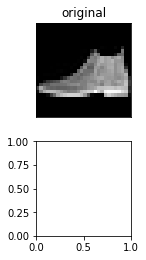

In [54]:
## 복원된 이미지 출력
n = 10   # 몇 개의 이미지 볼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)  # 행, 열, 몇 번째
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#---------------------------------------------------------------------------- 16:06

In [55]:
from tensorflow.keras import layers, losses
latent_dim = 64
# FFNN으로 생성된 모델
class Autoencoder(Model): ## 모델을 오토인코더가 상속을 받습니다
  def __init__(self, encoding_dim): # 구조를 설계
    super(Autoencoder, self).__init__() ## 먼저 모델의 초기화(__init__)를 호출
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
        layers.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu')) 
        layers.add(MaxPooling2D(pool_size=2, padding='same'))
        layers.add(Conv2D(8, kernel_size=3, activation='relu', padding='same')) 
        layers.add(MaxPooling2D(pool_size=2, padding='same')) 
        layers.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # 4 x 4 x 4 x 64
    ])
    self.decoder = tf.keras.Sequential([
        # decoder 부분 -> 원본 생성
        layers.add(Conv2D(4, kernel_size=3, padding='same', activation='relu')) # 128 x 4 x 4 x 4
        layers.add(UpSampling2D()) 
        layers.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 사이즈가 128 x 8 x 8 x 4
        layers.add(UpSampling2D()) 
        layers.add(Conv2D(16, kernel_size=3, activation='relu')) 
        layers.add(UpSampling2D())    
        layers.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')) # 784
        layers.reshape(28, 28)
    ])
  def call(self, x): # call의 오버로딩 : 클래스를 함수처럼 호출할 때 사용
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder= Autoencoder(latent_dim)

SyntaxError: ignored

In [56]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.0670 - val_loss: 0.0657
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0659 - val_loss: 0.0653
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0657 - val_loss: 0.0650
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0652 - val_loss: 0.0646
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0650 - val_loss: 0.0645
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0649 - val_loss: 0.0644
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0648 - val_loss: 0.0643
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0647 - val_loss: 0.0642
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0646 - val_loss: 0.0642

In [58]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

TypeError: ignored

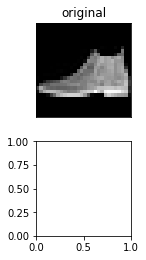

In [59]:
## 복원된 이미지 출력
n = 10   # 몇 개의 이미지 볼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)  # 행, 열, 몇 번째
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

NameError: ignored

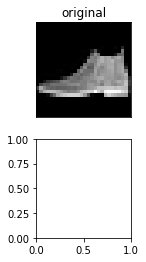

In [60]:
# 정답
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# denoising autoencoder

In [61]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# 차원을 늘리는 이유 : CNN은 4차원으로 데이터가 입력
x_train = x_train[..., tf.newaxis] # 말단에 차원을 확대해서
x_test = x_test[..., tf.newaxis]
print(x_train.shape) # 4차원 데이터로 생성
# FFNN에서는 이미지가 60000, 28, 28 이런식으로 들어감 ## 16:47

(60000, 28, 28, 1)


In [62]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
# 부동소수점 이미지의 범위는 0 ~ 1 사이로 정규화된 이미지
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

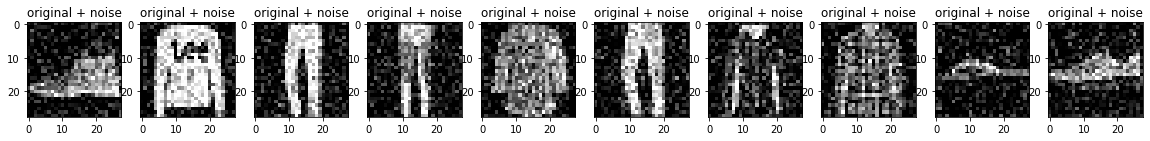

In [63]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i])) ## 16:48
  plt.gray()
plt.show()

In [64]:
## 16:45 ## 17:07
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)), # 명시적으로 입력 데이터 사이즈를 표현
        # ? 28, 28, 1
        # ? 14, 14, 16
        layers.Conv2D(16, (3, 3), activation='relu', padding = 'same', strides=2), 
        # ? 7, 7, 8 ## 그럼 몇개의 특성으로 잡아낸거에요? 7 * 7 * 8 이니까 392개의 주성분
        # 2개씩 건너 뛰게 되는 것 - pooling을 더 선호한다( 더 정확하기 때문 ) ## 중복 방지(strides=2)
        layers.Conv2D(8, (3, 3), activation='relu', padding = 'same', strides=2)]) # 392개의 주성분
    self.decoder = tf.keras.Sequential([
        # 계산의 정확성은 UpSampling보다 더 정교하다고 볼 수 있음
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), ## 사이즈가 배로 넘어가 # ? 14 14 8
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), # ? 28 28 16
        layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) #?, 28, 28, 1 # 복원된 이미지
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = Denoise()
    

In [65]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), # 이미지가 28x28 픽셀
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),  #Conv2D(필터 수, 커널의 (행,열) ...)  # zero padding
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])  # output크기 맞춤
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [66]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, X_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1137 - val_loss: 0.2065
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.2065
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.112

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  bx = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
plt.show()

NameError: ignored

NameError: ignored

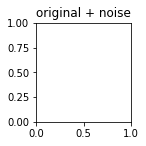

In [57]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i])) # 1차수를 제거 28 x 28 x 1 x 1 x 1
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()